In [ ]:
# # # cheking the number of cored this system has.
# !cat /proc/cpuinfo | grep "cpu cores" | uniq

# # GPU info
# !nvidia-smi

# # Amount of system RAM available to be used.
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
# print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

# #finding the recursion limit to avoid Augmentation recursion error 
# import sys
# print(sys.getrecursionlimit())

# #installing fastai
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the data 
#There are NaN values in the consumer_complaint_narrative column
train_raw = pd.read_csv('/content/drive/MyDrive/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
#Training data shape
train_raw.shape

(555957, 18)

In [ ]:
#Preprocessing the data 
#Extracting only those data whose consumer_complaint_narrative column is not null
#columns = 18
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

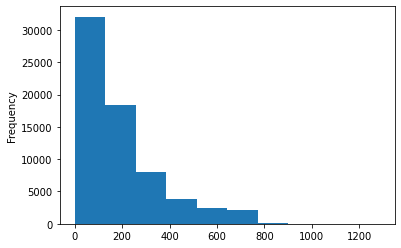

In [ ]:
#It splits the string into , separated values 
train_raw.consumer_complaint_narrative.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [ ]:
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [ ]:
train_raw.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'len_txt'],
      dtype='object')

In [ ]:
train_raw.shape

(66806, 19)

In [ ]:
#Select only the rows with more than 250 words 
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [ ]:
train_raw.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,len_txt
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,666
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,259
190251,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,Consent provided,Web,03/19/2015,Closed with non-monetary relief,Yes,No,1290534,301
190263,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,Consent provided,Web,03/19/2015,Closed with monetary relief,Yes,Yes,1292209,780
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159,558


In [ ]:
#selecting only the consumer_complaint_narrative and product columns
train_raw=train_raw[['consumer_complaint_narrative','product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card', 'Consumer Loan', 'Debt collection',
       'Credit reporting', 'Student loan', 'Bank account or service',
       'Money transfers', 'Payday loan', 'Prepaid card',
       'Other financial service'], dtype=object)

In [ ]:
#group similar products  dataframe.at = accessing a value using row column pair 
train_raw.at[train_raw['product']=='Credit reporting','product']= 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card or prepaid card', 'Consumer Loan',
       'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Student loan', 'Bank account or service', 'Money transfers',
       'Payday loan, title loan, or personal loan',
       'Other financial service'], dtype=object)

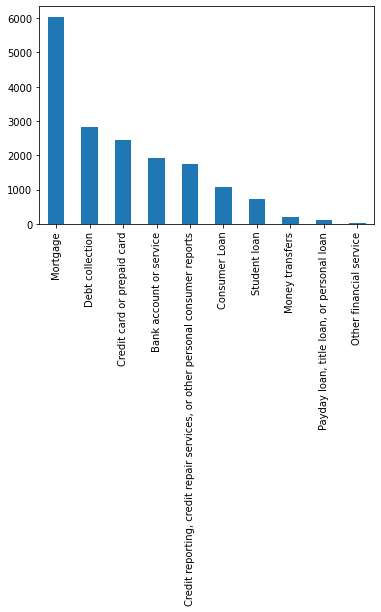

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset 

In [ ]:
#Renaming the columns 
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
#changing the categorical value column to integers

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [ ]:
len(np.unique(train_raw['label']))

10

In [ ]:
#creating the copy of the dataframe
#dataframe.copy(deep=True)  ==> This will create a copy and any changes to the copy will not be reflected in the original df
train = train_raw.copy()

In [ ]:
#reindexing to create randomness 
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
5273,XX/XX/XXXXDear Consumer Financial Protection B...,3
12871,I have a debt with XXXX XXXX XXXX ( XXXX ) I h...,4
2236,I have been a Bank of America Customer for alm...,6
3711,XXXX certified letters within a XXXX day perio...,4
1083,I received a call from a man whom phoned my pl...,4


In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
5273,XX XX XXXXDear Consumer Financial Protection B...,3
12871,I have a debt with XXXX XXXX XXXX XXXX I have ...,4
2236,I have been a Bank of America Customer for alm...,6
3711,XXXX certified letters within a XXXX day perio...,4
1083,I received a call from a man whom phoned my pl...,4


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,XX XX XXXXDear Consumer Financial Protection B...,3
1,I have a debt with XXXX XXXX XXXX XXXX I have ...,4


In [ ]:
train.shape

(17142, 2)

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

import bert
from bert import optimization

!pip install -q tf-models-official==2.4.0

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 60.0 MB/s 
     |████████████████████████████████| 352 kB 92.8 MB/s 
     |████████████████████████████████| 1.1 MB 63.8 MB/s 
     |████████████████████████████████| 99 kB 12.5 MB/s 
     |████████████████████████████████| 213 kB 83.4 MB/s 
     |████████████████████████████████| 596 kB 74.3 MB/s 
     |████████████████████████████████| 47.6 MB 113.4 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 



# Setting The Output Directory for BERT



In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
OUTPUT_DIR = '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3 *****


In [ ]:
print("Training Set Shape :", train.shape)
#print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (17142, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200] #overlapping 50 words in every chunks 
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def get_split_count(text1):
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  return n

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,XX XX XXXXDear Consumer Financial Protection B...,3,[XX XX XXXXDear Consumer Financial Protection ...
1,I have a debt with XXXX XXXX XXXX XXXX I have ...,4,[I have a debt with XXXX XXXX XXXX XXXX I have...
2,I have been a Bank of America Customer for alm...,6,[I have been a Bank of America Customer for al...
3,XXXX certified letters within a XXXX day perio...,4,[XXXX certified letters within a XXXX day peri...
4,I received a call from a man whom phoned my pl...,4,[I received a call from a man whom phoned my p...


In [ ]:
train['text_split_count'] = train[DATA_COLUMN].apply(get_split_count)
train.head()

,text,label,text_split,text_split_count
0,XX XX XXXXDear Consumer Financial Protection B...,3,[XX XX XXXXDear Consumer Financial Protection ...,2
1,I have a debt with XXXX XXXX XXXX XXXX I have ...,4,[I have a debt with XXXX XXXX XXXX XXXX I have...,4
2,I have been a Bank of America Customer for alm...,6,[I have been a Bank of America Customer for al...,2
3,XXXX certified letters within a XXXX day perio...,4,[XXXX certified letters within a XXXX day peri...,1
4,I received a call from a man whom phoned my pl...,4,[I received a call from a man whom phoned my p...,4


In [ ]:
train.shape

(17142, 4)

In [ ]:
count_1 =0
count_2 =0
count_3 =0
count_4 =0
count_5 =0
for i in train['text_split_count']:
  if i==5:
    count_5+=1
  if i==1:
    count_1+=1
  if i==2:
    count_2+=1
  if i==3:
    count_3+=1
  if i==4:
    count_4+=1

In [ ]:
print('count_1 ', count_1)
print('count_2 ', count_2)
print('count_3 ', count_3)
print('count_4 ', count_4)
print('count_5 ', count_5)

count_1  4045
count_2  6873
count_3  3264
count_4  2758
count_5  202


In [ ]:
#creating the test set
test_set = train[(train['text_split_count'].isin([1,2,3]))]

In [ ]:
test_set

,text,label,text_split,text_split_count
0,XX XX XXXXDear Consumer Financial Protection B...,3,[XX XX XXXXDear Consumer Financial Protection ...,2
2,I have been a Bank of America Customer for alm...,6,[I have been a Bank of America Customer for al...,2
3,XXXX certified letters within a XXXX day perio...,4,[XXXX certified letters within a XXXX day peri...,1
5,To whom it may concern I XXXX XXXX am i single...,6,[To whom it may concern I XXXX XXXX am i singl...,2
6,I have a Nationstar Mortgage after my loan was...,6,[I have a Nationstar Mortgage after my loan wa...,2
...,...,...,...,...
17136,I attest that I XXXX NEWBIE both own this acco...,3,[I attest that I XXXX NEWBIE both own this acc...,3
17137,I am a recipient of NYS XXXX My coverage renew...,3,[I am a recipient of NYS XXXX My coverage rene...,3
17138,I received a voicemail on my cell phone statin...,4,[I received a voicemail on my cell phone stati...,2
17139,I have a loan modification under HAMP IndyMac ...,6,[I have a loan modification under HAMP IndyMac...,2


In [ ]:
train = train[(train['text_split_count'].isin([4,5]))]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
test1, test_set = train_test_split(test_set, test_size=0.2, random_state=35)

In [ ]:
frames = [train, test1]
train = pd.concat(frames)

In [ ]:
train.shape , test_set.shape

((14305, 4), (2837, 4))

In [ ]:
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label,text_split,text_split_count
15961,In XXXX I put a significant down payment on an...,1,[In XXXX I put a significant down payment on a...,5
638,back in XX XX 2013 i filed a bankrutcy and one...,3,[back in XX XX 2013 i filed a bankrutcy and on...,1
13825,I started using this service on XXXX as i have...,2,[I started using this service on XXXX as i hav...,4
8816,Over the past month I have written many compla...,0,[Over the past month I have written many compl...,4
12757,My daughter needed financial support in getti...,2,[My daughter needed financial support in getti...,3


In [ ]:
train.shape, val.shape, test_set.shape

((11444, 4), (2861, 4), (2837, 4))

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(27414, 27414, 27414)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(6707, 6707, 6707)

In [ ]:
test_l = []
test_label_l = []
test_index_l = []
for idx,row in test_set.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_label_l.append(row['label'])
    test_index_l.append(idx)
len(test_l), len(test_label_l), len(test_index_l)

(5504, 5504, 5504)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,In XXXX I put a significant down payment on an...,1
1,title to my car all time taken away from XXXX ...,1
2,even been able to pay property take on for ove...,1
3,So again we made more calls and my wife made m...,1
4,our account since XXXX I called the local poli...,1


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,I was denied for a loan modification HAMP XXXX...,6
1,prove this is what Wells Fargo does to everyon...,6
2,I currently have a mortgage with BB T initiall...,6
3,were told we were unable to refinance due to t...,6
4,On XXXX XXXX I call XXXX XXXX XXXX and gave my...,2


In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df.head()

,text,label
0,I deposited a cashiers check for 2900 00 at Ba...,0
1,I believe BB T is intentionally reordering tra...,0
2,Bought a car in XXXX totaled it XXXX On XXXX m...,3
3,Hi My issue concerns the lack of accurate and ...,3
4,solved issue for more than a year at this poin...,3


In [ ]:
print('train_df shape : ',train_df.shape)
print('val_df shape : ',val_df.shape)
print('test_df shape : ',test_df.shape)

train_df shape :  (27414, 2)
val_df shape :  (6707, 2)
test_df shape :  (5504, 2)


# BERT: Data Preprocessing

In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train_df.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

0        <__main__.InputExample object at 0x7fd9919c7b10>
1        <__main__.InputExample object at 0x7fd993a0ae50>
2        <__main__.InputExample object at 0x7fd933d4dad0>
3        <__main__.InputExample object at 0x7fd933d4dd90>
4        <__main__.InputExample object at 0x7fd933d4dfd0>
                               ...                       
27409    <__main__.InputExample object at 0x7fd93346b890>
27410    <__main__.InputExample object at 0x7fd93346b8d0>
27411    <__main__.InputExample object at 0x7fd93346b910>
27412    <__main__.InputExample object at 0x7fd93346b950>
27413    <__main__.InputExample object at 0x7fd93346b990>
Length: 27414, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  In XXXX I put a significant down payment on an Acura XXXX form XXXX XXXX in Virginia XXXX with some financing help through Acura Finance Corp Now American Honda Finance Corp XXXX I made my monthly payments to American Honda Finance Corp for approximately 2 years before I was offered a lower interest rate on the loan from XXXX Bank in XXXX VA In XXXX XXXX XXXX Bank took over the loan and I began to make monthly payments to XXXX Bank up to XXXX XXXX XXXX when I made a significant payment to purchase the car outright yet never was given the title to the car Since that time my wife and I have spent hundreds of hours in the Bank and on the phone with various departments at the Bank the Honda Finance Corp the Federal Reserve and the Attorney General of XXXX and XXXX to get the title to my car all time taken away from XXXX our jobs costing us XXXX dollars As of today XXXX XXXX XXXX I still do not have the title

In [ ]:
val_InputExamples_1 = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
test_InputExamples_1 = test_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=200):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels,features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm
MAX_SEQ_LENGTH = 200

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.

train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)

test_features = convert_examples_to_features(tokenizer, test_InputExamples_1, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 5504/5504 [00:17<00:00, 314.32it/s]


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  In XXXX I put a significant down payment on an Acura XXXX form XXXX XXXX in Virginia XXXX with some financing help through Acura Finance Corp Now American Honda Finance Corp XXXX I made my monthly payments to American Honda Finance Corp for approximately 2 years before I was offered a lower interest rate on the loan from XXXX Bank in XXXX VA In XXXX XXXX XXXX Bank took over the loan and I began to make monthly payments to XXXX Bank up to XXXX XXXX XXXX when I made a significant payment to purchase the car outright yet never was given the title to the car Since that time my wife and I have spent hundreds of hours in the Bank and on the phone with various departments at the Bank the Honda Finance Corp the Federal Reserve and the Attorney General of XXXX and XXXX to get the title to my car all time taken away from XXXX our jobs costing us XXXX dollars As of today XXXX XXXX XXXX I still do not have the title to my car This is my families only car to get us to work groceries etc

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# # Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(1713, 10)

In [ ]:
#Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
print(f'Beginning Training!')
#current_time = datetime.time()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.346861, step = 0


INFO:tensorflow:loss = 2.346861, step = 0


INFO:tensorflow:global_step/sec: 2.05908


INFO:tensorflow:global_step/sec: 2.05908


INFO:tensorflow:loss = 1.0559839, step = 100 (48.567 sec)


INFO:tensorflow:loss = 1.0559839, step = 100 (48.567 sec)


INFO:tensorflow:global_step/sec: 2.48682


INFO:tensorflow:global_step/sec: 2.48682


INFO:tensorflow:loss = 0.87870085, step = 200 (40.212 sec)


INFO:tensorflow:loss = 0.87870085, step = 200 (40.212 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.11885


INFO:tensorflow:global_step/sec: 2.11885


INFO:tensorflow:loss = 0.29442847, step = 300 (47.195 sec)


INFO:tensorflow:loss = 0.29442847, step = 300 (47.195 sec)


INFO:tensorflow:global_step/sec: 2.48549


INFO:tensorflow:global_step/sec: 2.48549


INFO:tensorflow:loss = 0.2825665, step = 400 (40.234 sec)


INFO:tensorflow:loss = 0.2825665, step = 400 (40.234 sec)


INFO:tensorflow:global_step/sec: 2.48417


INFO:tensorflow:global_step/sec: 2.48417


INFO:tensorflow:loss = 0.53617096, step = 500 (40.255 sec)


INFO:tensorflow:loss = 0.53617096, step = 500 (40.255 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.19331


INFO:tensorflow:global_step/sec: 2.19331


INFO:tensorflow:loss = 0.4894623, step = 600 (45.594 sec)


INFO:tensorflow:loss = 0.4894623, step = 600 (45.594 sec)


INFO:tensorflow:global_step/sec: 2.48304


INFO:tensorflow:global_step/sec: 2.48304


INFO:tensorflow:loss = 1.0728186, step = 700 (40.272 sec)


INFO:tensorflow:loss = 1.0728186, step = 700 (40.272 sec)


INFO:tensorflow:global_step/sec: 2.48347


INFO:tensorflow:global_step/sec: 2.48347


INFO:tensorflow:loss = 1.7270198, step = 800 (40.268 sec)


INFO:tensorflow:loss = 1.7270198, step = 800 (40.268 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.13511


INFO:tensorflow:global_step/sec: 2.13511


INFO:tensorflow:loss = 0.75936735, step = 900 (46.835 sec)


INFO:tensorflow:loss = 0.75936735, step = 900 (46.835 sec)


INFO:tensorflow:global_step/sec: 2.48254


INFO:tensorflow:global_step/sec: 2.48254


INFO:tensorflow:loss = 0.5213908, step = 1000 (40.282 sec)


INFO:tensorflow:loss = 0.5213908, step = 1000 (40.282 sec)


INFO:tensorflow:global_step/sec: 2.48357


INFO:tensorflow:global_step/sec: 2.48357


INFO:tensorflow:loss = 0.8483413, step = 1100 (40.264 sec)


INFO:tensorflow:loss = 0.8483413, step = 1100 (40.264 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.13745


INFO:tensorflow:global_step/sec: 2.13745


INFO:tensorflow:loss = 0.6205458, step = 1200 (46.785 sec)


INFO:tensorflow:loss = 0.6205458, step = 1200 (46.785 sec)


INFO:tensorflow:global_step/sec: 2.48279


INFO:tensorflow:global_step/sec: 2.48279


INFO:tensorflow:loss = 1.03423, step = 1300 (40.277 sec)


INFO:tensorflow:loss = 1.03423, step = 1300 (40.277 sec)


INFO:tensorflow:global_step/sec: 2.48338


INFO:tensorflow:global_step/sec: 2.48338


INFO:tensorflow:loss = 0.533647, step = 1400 (40.268 sec)


INFO:tensorflow:loss = 0.533647, step = 1400 (40.268 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 2.15828


INFO:tensorflow:global_step/sec: 2.15828


INFO:tensorflow:loss = 0.74886835, step = 1500 (46.333 sec)


INFO:tensorflow:loss = 0.74886835, step = 1500 (46.333 sec)


INFO:tensorflow:global_step/sec: 2.48222


INFO:tensorflow:global_step/sec: 2.48222


INFO:tensorflow:loss = 0.7395182, step = 1600 (40.287 sec)


INFO:tensorflow:loss = 0.7395182, step = 1600 (40.287 sec)


INFO:tensorflow:global_step/sec: 2.48361


INFO:tensorflow:global_step/sec: 2.48361


INFO:tensorflow:loss = 0.34589905, step = 1700 (40.264 sec)


INFO:tensorflow:loss = 0.34589905, step = 1700 (40.264 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1713...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1713...


INFO:tensorflow:Saving checkpoints for 1713 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1713 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1713...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1713...


INFO:tensorflow:Loss for final step: 0.7017964.


INFO:tensorflow:Loss for final step: 0.7017964.


In [ ]:
# #Run this If you want to load the model 
# #Loading a specific check point : 
# warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/MCPCC/model.ckpt-1982.meta')


# model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps)

# estimator=tf.estimator.Estimator(model_fn=model_fn,
#                        config=run_config,
#                        params={"batch_size": BATCH_SIZE},
#                        warm_start_from=warm_start)

In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-10-22T16:17:36


INFO:tensorflow:Starting evaluation at 2021-10-22T16:17:36


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt-1713


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt-1713


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 59.45907s


INFO:tensorflow:Inference Time : 59.45907s


INFO:tensorflow:Finished evaluation at 2021-10-22-16:18:35


INFO:tensorflow:Finished evaluation at 2021-10-22-16:18:35


INFO:tensorflow:Saving dict for global step 1713: eval_accuracy = 0.8544804, false_negatives = 157.0, false_positives = 165.0, global_step = 1713, loss = 0.477306, true_negatives = 560.0, true_positives = 5825.0


INFO:tensorflow:Saving dict for global step 1713: eval_accuracy = 0.8544804, false_negatives = 157.0, false_positives = 165.0, global_step = 1713, loss = 0.477306, true_negatives = 560.0, true_positives = 5825.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1713: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt-1713


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1713: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_Cnt3/model.ckpt-1713


{'eval_accuracy': 0.8544804,
 'false_negatives': 157.0,
 'false_positives': 165.0,
 'global_step': 1713,
 'loss': 0.477306,
 'true_negatives': 560.0,
 'true_positives': 5825.0}

# Extract Embeddings from BERT

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  #input_features = convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_features = convert_examples_to_features(tokenizer,input_examples,MAX_SEQ_LENGTH )
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape , test_df.shape

((27414, 2), (6707, 2), (5504, 2))

In [ ]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 27414/27414 [01:29<00:00, 307.57it/s]


In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 6707/6707 [00:21<00:00, 314.92it/s]


In [ ]:
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 5504/5504 [00:17<00:00, 306.01it/s]


In [ ]:
 tr_emb.shape,val_emb.shape,test_emb.shape

((27414, 768), (6707, 768), (5504, 768))

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.1610043, 0.4527748, -0.9387181, 0.3837650...",1
1,"[[0.326586, -0.52607155, -0.82651794, -0.53501...",3
2,"[[-0.6700569, 0.29940653, 0.93665946, 0.660795...",2
3,"[[-0.8896185, -0.57728976, 0.86916393, 0.49304...",0
4,"[[-0.6699596, -0.18776351, -0.9814323, 0.92064...",2


In [ ]:
def finding_mean(mat):
    return np.mean(mat, axis=0)

In [ ]:
df_train['mean_emb'] = df_train['emb'].apply(finding_mean)

In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[0.7754092, -0.7157613, -0.7628019, 0.7183220...",6
1,"[[0.73216677, -0.754278, -0.7485629, 0.8141649...",6
2,"[[0.67341906, -0.50461674, -0.9831959, 0.73962...",2
3,"[[0.6199794, -0.040450368, -0.9822259, 0.64767...",4
4,"[[0.6533263, 0.23176861, -0.97694004, 0.375422...",4


In [ ]:
df_val['mean_emb'] = df_val['emb'].apply(finding_mean)

In [ ]:
df_val.head()

,emb,label,mean_emb
0,"[[0.7754092, -0.7157613, -0.7628019, 0.7183220...",6,"[0.77188873, -0.7107458, -0.77146053, 0.745528..."
1,"[[0.73216677, -0.754278, -0.7485629, 0.8141649...",6,"[0.7803488, -0.74760324, -0.71247625, 0.726761..."
2,"[[0.67341906, -0.50461674, -0.9831959, 0.73962...",2,"[0.18005382, -0.46647507, -0.98544896, 0.85398..."
3,"[[0.6199794, -0.040450368, -0.9822259, 0.64767...",4,"[0.644433, 0.025034526, -0.98827696, 0.6941883..."
4,"[[0.6533263, 0.23176861, -0.97694004, 0.375422...",4,"[0.23425579, 0.049994316, -0.94592524, 0.67035..."


In [ ]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
telabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  telabel_l_final.append(test_set.loc[k]['label'])

df_test = pd.DataFrame({'emb': test_l_final, 'label': telabel_l_final})
df_test.head()

,emb,label
0,"[[-0.8872524, -0.5151761, 0.9619557, 0.4168277...",0
1,"[[-0.8493523, -0.47106075, 0.85801953, 0.53620...",0
2,"[[0.05610805, -0.49450946, -0.9561615, 0.44017...",3
3,"[[0.4641734, -0.6316321, -0.921132, 0.2067978,...",3
4,"[[-0.7124537, -0.13783441, 0.9466789, 0.398362...",0


In [ ]:
df_test['mean_emb'] = df_test['emb'].apply(finding_mean)

In [ ]:
df_test.head()

,emb,label,mean_emb
0,"[[-0.8872524, -0.5151761, 0.9619557, 0.4168277...",0,"[-0.8872524, -0.5151761, 0.9619557, 0.41682774..."
1,"[[-0.8493523, -0.47106075, 0.85801953, 0.53620...",0,"[-0.8493523, -0.47106075, 0.85801953, 0.536203..."
2,"[[0.05610805, -0.49450946, -0.9561615, 0.44017...",3,"[0.05610805, -0.49450946, -0.9561615, 0.440174..."
3,"[[0.4641734, -0.6316321, -0.921132, 0.2067978,...",3,"[0.53415215, -0.63203067, -0.9163149, 0.107048..."
4,"[[-0.7124537, -0.13783441, 0.9466789, 0.398362...",0,"[-0.3916529, 0.033770084, 0.8848713, 0.4719766..."


# High variance Chunk dataset 

In [ ]:
#Stacking
train_var=[]
for data in range(df_train['emb'].shape[0]):
  temp={}
  if len(df_train['emb'][data]) !=1:
    covMatrix = np.cov(df_train['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_train['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_train['emb'][data]
  train_var.append(temp[data])

In [ ]:
df_train_var = pd.DataFrame({'emb': train_var, 'label': df_train['label']})
df_train_var.head()
df_train_var['mean_emb'] = df_train_var['emb'].apply(finding_mean)

In [ ]:
df_train.head(2)

,emb,label,mean_emb
0,"[[-0.1610043, 0.4527748, -0.9387181, 0.3837650...",1,"[-0.20329411, 0.37748846, -0.93513477, 0.50127..."
1,"[[0.326586, -0.52607155, -0.82651794, -0.53501...",3,"[0.326586, -0.52607155, -0.82651794, -0.535012..."


In [ ]:
df_train_var.head(2)

,emb,label,mean_emb
0,"[[-0.1610043, 0.4527748, -0.9387181, 0.3837650...",1,"[-0.1610043, 0.4527748, -0.9387181, 0.38376507..."
1,"[[0.326586, -0.52607155, -0.82651794, -0.53501...",3,"[0.326586, -0.52607155, -0.82651794, -0.535012..."


In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_val.head(2)

,emb,label,mean_emb
0,"[[0.7754092, -0.7157613, -0.7628019, 0.7183220...",6,"[0.77188873, -0.7107458, -0.77146053, 0.745528..."
1,"[[0.73216677, -0.754278, -0.7485629, 0.8141649...",6,"[0.7803488, -0.74760324, -0.71247625, 0.726761..."


In [ ]:
##creating the validation set 
val_var=[]
for data in range(df_val['emb'].shape[0]):
  temp={}
  if len(df_val['emb'][data]) !=1:
    covMatrix = np.cov(df_val['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_val['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_val['emb'][data]
  val_var.append(temp[data])

df_val_var = pd.DataFrame({'emb': val_var, 'label': df_val['label']})
df_val_var.head()
df_val_var['mean_emb'] = df_val_var['emb'].apply(finding_mean)

In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.head(2)

,emb,label,mean_emb
0,"[[-0.8872524, -0.5151761, 0.9619557, 0.4168277...",0,"[-0.8872524, -0.5151761, 0.9619557, 0.41682774..."
1,"[[-0.8493523, -0.47106075, 0.85801953, 0.53620...",0,"[-0.8493523, -0.47106075, 0.85801953, 0.536203..."


In [ ]:
##creating the test data 
test_var=[]
for data in range(df_test['emb'].shape[0]):
  temp={}
  if len(df_test['emb'][data]) !=1:
    covMatrix = np.cov(df_test['emb'][data],bias=True)
    eigen_vals , eigen_vectors = np.linalg.eig(covMatrix)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigen_vals[i]), eigen_vectors[:,i]) for i in range(len(eigen_vals))]

    tot = sum(eigen_vals)
    var_exp = [(i / tot)*100 for i in eigen_vals]
    cum_var_exp = np.cumsum(var_exp)

    for i in range(len(var_exp)):
      if var_exp[i] > 5:
         emb_l= df_test['emb'][data][i]
         if data in temp.keys():
            temp[data]  =np.vstack([temp[data],emb_l])  
         else:
            temp[data] = [emb_l]
  else:
    temp[data] =df_test['emb'][data]
  test_var.append(temp[data])

df_test_var = pd.DataFrame({'emb': test_var, 'label': df_test['label']})
df_test_var.head()
df_test_var['mean_emb'] = df_test_var['emb'].apply(finding_mean)

In [ ]:
df_train_var.shape , df_val_var.shape, df_test_var.shape

((11444, 3), (2861, 3), (2837, 3))

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11444, 3), (2861, 3), (2837, 3))

In [ ]:
type(df_train_var['emb'][2])

list

In [ ]:
type(df_train['emb'][2])

numpy.ndarray

In [ ]:
def get_split_count_1(text):
  return len(text)

In [ ]:
df_train_var['text_split_count'] = df_train_var['emb'].apply(get_split_count_1)
df_val_var['text_split_count'] = df_val_var['emb'].apply(get_split_count_1)
df_test_var['text_split_count'] = df_test_var['emb'].apply(get_split_count_1)

In [ ]:
df_train['text_split_count'] = df_train['emb'].apply(get_split_count_1)
df_val['text_split_count'] = df_val['emb'].apply(get_split_count_1)
df_test['text_split_count'] = df_test['emb'].apply(get_split_count_1)

In [ ]:
max(df_train['text_split_count'].unique())

5

In [ ]:
max(df_train_var['text_split_count'].unique())

4

In [ ]:
max(df_test['text_split_count'].unique())

3

In [ ]:
max(df_test_var['text_split_count'].unique())

3

# LSTM Model Creation

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 768)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               347600    
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11444, 4), (2861, 4), (2837, 4))

In [ ]:
num_sequences = len(df_train_var['emb'].to_list())
batch_size = 4
batches_per_epoch =  2861
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val_var['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 2861
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
ES=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit_generator(train_generator_encoder(df_train_var), steps_per_epoch=batches_per_epoch, epochs=50,validation_data=val_generator_encoder(df_val_var), validation_steps=batches_per_epoch_val,callbacks=[ES])

In [ ]:
model.fit_generator(train_generator(df_train_var), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_var), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


2859/2861 [============================>.] - ETA: 0s - batch: 1429.0000 - size: 4.0000 - loss: 0.3588 - acc: 0.9058

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2861/2861 [==============================] - 18s 6ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.3586 - acc: 0.9059 - val_loss: 0.4071 - val_acc: 0.8902 - lr: 0.0010
Epoch 2/10
2861/2861 [==============================] - 17s 6ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.3170 - acc: 0.9139 - val_loss: 0.4038 - val_acc: 0.8923 - lr: 0.0010
Epoch 3/10
2861/2861 [==============================] - 18s 6ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.3080 - acc: 0.9129 - val_loss: 0.3927 - val_acc: 0.8920 - lr: 0.0010
Epoch 4/10
2854/2861 [============================>.] - ETA: 0s - batch: 1426.5000 - size: 4.0000 - loss: 0.3020 - acc: 0.9135
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
2861/2861 [==============================] - 17s 6ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.3014 - acc: 0.9137 - val_loss: 0.3833 - val_acc: 0.8923 - lr: 0.0010
Epoch 5/10
2861/2861 [==============================] - 17s 6ms/step - batch: 1430.0000

In [ ]:
num_sequences_val = len(df_test_var['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 2837
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.42664311203415844, 0.8808601]

In [ ]:
y_proba1=model.predict(val_generator(df_test_var), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred1=[]
for i in y_proba1:
    max_index_row = np.argmax(i, axis=0)
    y_pred1.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred1, df_test_var['label']))
print('Classification Report')
print(classification_report(y_pred1, df_test_var['label']))

Confusion Matrix
[[286   4  24   2   2  15   8   0   1   0]
 [  6 116   1   3  11   0   9   0  14   0]
 [ 18   7 366   7  13   3   2   0   0   0]
 [  0   5   2 276  13   1   2   0   0   3]
 [  4   9  19  21 437   0   7   0   5   9]
 [  6   0   1   0   0  17   1   3   1   0]
 [  9   8   4   7  22   0 902   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   1   0   0   0   1   0]
 [  1   2   0   4  13   0   1   1   0  98]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       342
           1       0.76      0.72      0.74       160
           2       0.88      0.88      0.88       416
           3       0.86      0.91      0.89       302
           4       0.85      0.86      0.85       511
           5       0.47      0.59      0.52        29
           6       0.97      0.95      0.96       954
           7       0.00      0.00      0.00         0
           8       0.04      0.33      0.08

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat1 = confusion_matrix(y_pred1, df_test_var['label'])

In [ ]:
diag = np.diagonal(mat1)
sum(diag)

2499

# Output for Stack of all Chunks 

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 768)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               347600    
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11444, 3), (2861, 3), (2837, 3))

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 4
batches_per_epoch =  2861
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 2861
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


2857/2861 [============================>.] - ETA: 0s - batch: 1428.0000 - size: 4.0000 - loss: 0.3449 - acc: 0.9106

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2861/2861 [==============================] - 25s 9ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.3448 - acc: 0.9106 - val_loss: 0.4359 - val_acc: 0.8798 - lr: 0.0010
Epoch 2/10
2861/2861 [==============================] - 23s 8ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.3061 - acc: 0.9153 - val_loss: 0.4320 - val_acc: 0.8784 - lr: 0.0010
Epoch 3/10
2861/2861 [==============================] - 23s 8ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.2922 - acc: 0.9204 - val_loss: 0.4382 - val_acc: 0.8773 - lr: 0.0010
Epoch 4/10
2861/2861 [==============================] - ETA: 0s - batch: 1430.0000 - size: 4.0000 - loss: 0.2911 - acc: 0.9182
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
2861/2861 [==============================] - 23s 8ms/step - batch: 1430.0000 - size: 4.0000 - loss: 0.2911 - acc: 0.9182 - val_loss: 0.4407 - val_acc: 0.8784 - lr: 0.0010
Epoch 5/10
2861/2861 [==============================] - 23s 8ms/step - batch: 1430.0000

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 2837
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.41300044103313144, 0.8861473]

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 1
batches_per_epoch_val = 2837
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
y_proba1=model.predict(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred1=[]
for i in y_proba1:
    max_index_row = np.argmax(i, axis=0)
    y_pred1.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred1, df_test['label']))
print('Classification Report')
print(classification_report(y_pred1, df_test['label']))

Confusion Matrix
[[240   4  17   1   3  11   1   1   0   1]
 [  2 141   1   2   9   0   4   0   8   0]
 [ 22  12 377   3  17   4   2   0   0   0]
 [  1   2   2 270   4   0   0   0   0   1]
 [  6  10  14  24 411   1   5   1   8   8]
 [  9   1   2   0   0  22   0   0   0   1]
 [ 12  15   4   5  25   2 924   3   1   3]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   5   0   0   1   0   0   0   3   0]
 [  0   4   0   4  14   0   0   0   0 126]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       279
           1       0.73      0.84      0.78       167
           2       0.90      0.86      0.88       437
           3       0.87      0.96      0.92       280
           4       0.85      0.84      0.85       488
           5       0.55      0.63      0.59        35
           6       0.99      0.93      0.96       994
           7       0.00      0.00      0.00         0
           8       0.15      0.33      0.21

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat1 = confusion_matrix(y_pred1, df_test['label'])

In [ ]:
print(mat1)

[[240   4  17   1   3  11   1   1   0   1]
 [  2 141   1   2   9   0   4   0   8   0]
 [ 22  12 377   3  17   4   2   0   0   0]
 [  1   2   2 270   4   0   0   0   0   1]
 [  6  10  14  24 411   1   5   1   8   8]
 [  9   1   2   0   0  22   0   0   0   1]
 [ 12  15   4   5  25   2 924   3   1   3]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   5   0   0   1   0   0   0   3   0]
 [  0   4   0   4  14   0   0   0   0 126]]


In [ ]:
diag = np.diagonal(mat1)
sum(diag)

2514

In [ ]:
sum(sum(mat1))-sum(diag)

323

In [ ]:
#Just for reference -->DO NOT RUN IT
# #BERT: Fine Tuning Training & Evaluating
# print(f'Beginning Training!')
# #current_time = datetime.time()
# estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
# #print("Training took time ", datetime.now() - current_time)

In [ ]:
#Training for count 3 Ran by Jan ...Looks like BERT finetuned with chunks 1,2,3,4,5
#Just for reference -->DO NOT RUN IT
#BERT: Fine Tuning Training & Evaluating
print(f'Beginning Training!')
#current_time = datetime.time()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.5042224, step = 0


INFO:tensorflow:loss = 2.5042224, step = 0


INFO:tensorflow:global_step/sec: 2.05608


INFO:tensorflow:global_step/sec: 2.05608


INFO:tensorflow:loss = 1.1643467, step = 100 (48.638 sec)


INFO:tensorflow:loss = 1.1643467, step = 100 (48.638 sec)


INFO:tensorflow:global_step/sec: 2.47923


INFO:tensorflow:global_step/sec: 2.47923


INFO:tensorflow:loss = 1.4491696, step = 200 (40.335 sec)


INFO:tensorflow:loss = 1.4491696, step = 200 (40.335 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.16957


INFO:tensorflow:global_step/sec: 2.16957


INFO:tensorflow:loss = 0.71626365, step = 300 (46.093 sec)


INFO:tensorflow:loss = 0.71626365, step = 300 (46.093 sec)


INFO:tensorflow:global_step/sec: 2.4789


INFO:tensorflow:global_step/sec: 2.4789


INFO:tensorflow:loss = 0.67747253, step = 400 (40.339 sec)


INFO:tensorflow:loss = 0.67747253, step = 400 (40.339 sec)


INFO:tensorflow:global_step/sec: 2.48087


INFO:tensorflow:global_step/sec: 2.48087


INFO:tensorflow:loss = 0.33643615, step = 500 (40.309 sec)


INFO:tensorflow:loss = 0.33643615, step = 500 (40.309 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.18356


INFO:tensorflow:global_step/sec: 2.18356


INFO:tensorflow:loss = 0.28697303, step = 600 (45.796 sec)


INFO:tensorflow:loss = 0.28697303, step = 600 (45.796 sec)


INFO:tensorflow:global_step/sec: 2.47908


INFO:tensorflow:global_step/sec: 2.47908


INFO:tensorflow:loss = 0.36655343, step = 700 (40.338 sec)


INFO:tensorflow:loss = 0.36655343, step = 700 (40.338 sec)


INFO:tensorflow:global_step/sec: 2.48047


INFO:tensorflow:global_step/sec: 2.48047


INFO:tensorflow:loss = 0.8295051, step = 800 (40.315 sec)


INFO:tensorflow:loss = 0.8295051, step = 800 (40.315 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.15033


INFO:tensorflow:global_step/sec: 2.15033


INFO:tensorflow:loss = 0.84399354, step = 900 (46.504 sec)


INFO:tensorflow:loss = 0.84399354, step = 900 (46.504 sec)


INFO:tensorflow:global_step/sec: 2.4795


INFO:tensorflow:global_step/sec: 2.4795


INFO:tensorflow:loss = 0.6469933, step = 1000 (40.331 sec)


INFO:tensorflow:loss = 0.6469933, step = 1000 (40.331 sec)


INFO:tensorflow:global_step/sec: 2.48145


INFO:tensorflow:global_step/sec: 2.48145


INFO:tensorflow:loss = 0.6729224, step = 1100 (40.299 sec)


INFO:tensorflow:loss = 0.6729224, step = 1100 (40.299 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.11417


INFO:tensorflow:global_step/sec: 2.11417


INFO:tensorflow:loss = 0.37728837, step = 1200 (47.299 sec)


INFO:tensorflow:loss = 0.37728837, step = 1200 (47.299 sec)


INFO:tensorflow:global_step/sec: 2.48048


INFO:tensorflow:global_step/sec: 2.48048


INFO:tensorflow:loss = 0.2639888, step = 1300 (40.316 sec)


INFO:tensorflow:loss = 0.2639888, step = 1300 (40.316 sec)


INFO:tensorflow:global_step/sec: 2.48054


INFO:tensorflow:global_step/sec: 2.48054


INFO:tensorflow:loss = 0.6219491, step = 1400 (40.314 sec)


INFO:tensorflow:loss = 0.6219491, step = 1400 (40.314 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 2.19169


INFO:tensorflow:global_step/sec: 2.19169


INFO:tensorflow:loss = 1.0137844, step = 1500 (45.626 sec)


INFO:tensorflow:loss = 1.0137844, step = 1500 (45.626 sec)


INFO:tensorflow:global_step/sec: 2.48083


INFO:tensorflow:global_step/sec: 2.48083


INFO:tensorflow:loss = 0.079121515, step = 1600 (40.309 sec)


INFO:tensorflow:loss = 0.079121515, step = 1600 (40.309 sec)


INFO:tensorflow:global_step/sec: 2.47879


INFO:tensorflow:global_step/sec: 2.47879


INFO:tensorflow:loss = 0.41065043, step = 1700 (40.343 sec)


INFO:tensorflow:loss = 0.41065043, step = 1700 (40.343 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1709...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1709...


INFO:tensorflow:Saving checkpoints for 1709 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1709 into /content/drive/MyDrive/ModCheckpoint_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1709...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1709...


INFO:tensorflow:Loss for final step: 0.38386738.


INFO:tensorflow:Loss for final step: 0.38386738.
